## Imports
Firs we import the libreries that we will use.

In [66]:
import os
import pandas as pd
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from geopy.geocoders import Nominatim
import cv2
from sklearn.metrics import f1_score
np.random.seed(1)

## Data science
We will load the dato from the available datasets.

In [166]:
data_path = 'C:/Users/Usuario/Desktop/HACK/hack2/NSVM_nuwe_hackaton/train_test_data'

train_path = f'{data_path}/train.csv'
train_states_path = f'{data_path}/train_states.csv'
test_path = f'{data_path}/test.csv'
test_states_path = f'{data_path}/test_states.csv'
train_image_path = f'{data_path}/train'
test_image_path = f'{data_path}/test'

In [167]:
# Read the train.csv file
train_df = pd.read_csv(train_states_path)
test_df = pd.read_csv(test_states_path)

train_df.head()

,label,latitude,longitude,year,example_path,state
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png,Kalimantan Tengah
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png,Kepulauan Bangka Belitung
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png,Riau
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png,Sumatera Selatan
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png,Riau


In [168]:
test_df.shape

(635, 5)

In [169]:
train_df.shape

(1714, 6)

We have applied data engineering to the dataset provided. As the latitude and longitude data are not really usefull by itselfs we have used a Python library to obtain the country where that coordinates are located. As we have seen that every picture was from Indonesia, then we have decieded to use the state. So we have obtained the state of each image and we have used a ML technique known as One Hot Encoding in order to encode the states and to convert the names of the states to usefull information to feed into the model.

In [69]:
geolocator = Nominatim(user_agent="NSVM_nuwe")

# Function to get the country name from the latitude and longitude values from the dataset train
def get_country_state(lat, long):
    location = geolocator.reverse(str(lat) + ', ' + str(long))
    address = location.raw['address']
    country = address.get('country', '')
    state = address.get('state', '')
    print(country, state)
    return country, state

# Apply the function to the train dataframe
train_df['country'], train_df['state'] = zip(*train_df.apply(lambda x: get_country_state(x['latitude'], x['longitude']), axis=1))

print(train_df['country'].value_counts())
print(train_df['country'].unique())


Indonesia Kalimantan Tengah
Indonesia Kepulauan Bangka Belitung
Indonesia Riau
Indonesia Sumatera Selatan
Indonesia Riau
Indonesia Jambi
Indonesia Riau
Indonesia Kalimantan Barat


KeyboardInterrupt: 

In [87]:
print(len(train_df['state'].unique()))
print(train_df['state'].unique())

32
['Kalimantan Tengah' 'Kepulauan Bangka Belitung' 'Riau' 'Sumatera Selatan'
 'Jambi' 'Kalimantan Barat' 'Sumatera Utara' 'Sulawesi Selatan'
 'Sumatera Barat' 'Sulawesi Tenggara' 'Aceh' 'Sulawesi Tengah'
 'Kalimantan Timur' 'Sulawesi Utara' 'Papua Selatan' 'Gorontalo'
 'Maluku Utara' 'Papua Tengah' 'Papua Barat Daya' 'Maluku' 'Papua'
 'Bengkulu' 'Kalimantan Utara' 'Papua Barat' 'Kalimantan Selatan'
 'Sulawesi Barat' 'Jawa Timur' 'Lampung' 'Banten' 'Jawa Barat'
 'Papua Pegunungan' 'Kepulauan Riau']


Here we can see an example of one image of the dataset

In [170]:
aux = train_df['state'].unique()
for i in aux:
    train_df['state_'+aux] = 0
    test_df['state_'+aux] = 0


In [171]:
for i in range(len(train_df)):
    for j in aux:
        if(train_df.iloc[i].state == j):
            train_df.iloc[i, aux.tolist().index(train_df.iloc[i].state)+6] = 1

In [172]:
for i in range(len(test_df)):
    for j in aux:
        if(test_df.iloc[i].state == j):
            test_df.iloc[i, aux.tolist().index(test_df.iloc[i].state)+5] = 1

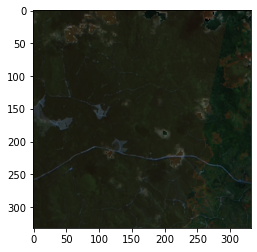

In [174]:
img = cv2.imread(train_df.example_path[0])
img_plot = plt.imshow(img)

We can appreciate the shape of the images that we will resize in order to have a better resutls and to fit them into the pre-trainned models

In [175]:
img.shape

(332, 332, 3)

As we will use a complex model that will use both images and text data, we have designed a Data generator to feed the neural network with the data. The Data generator reads the images, normalizes the images, resizes the images and obtains the text data, sending it to the machine learning model. 

In [194]:
class Data_generator():
    """
    Data generator
    """
    def __init__(self, train_df, train_size, width, height, channels):
        self.train_df = train_df
        self.train_size = train_size
        self.width = width
        self.height = height
        self.channels = channels

    def generate_split_indexes(self):
        '''
        '''
        np.random.seed(1)
        permutation = np.random.permutation(len(self.train_df))
        index = int(len(self.train_df) * self.train_size)
        train_index = permutation[:index]
        test_index = permutation[index:]

        return train_index, test_index

    def read_image(self, filepath):

        img = cv2.imread(filepath)
        return img

    def normalize(self, img):
        """Normalize the volume"""
        norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm = norm.astype("float64")
        return img

    def resize_image(self, img):
        # Get current depth
        resized_image = cv2.resize(img, (self.width, self.height))
        return resized_image

    def preprocess_image(self, path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        # Read scan
        img = self.read_image(path)
        # Normalize
        img = self.normalize(img)
        img = self.resize_image(img)

        return img

    def generate_data(self, indexes, is_training, batch_size=32):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        # arrays to store our batched data
        images, text, labels = [], [], []
        if(is_training):
            while True:
                for index in indexes:
                    row = self.train_df.iloc[index]

                    img_path = row['example_path']
                    images.append(self.preprocess_image(img_path))

                    labels.append(to_categorical(row['label'], 3))
                    text.append(row[['year', 'state_Aceh', 'state_Banten', 'state_Bengkulu', 'state_Gorontalo',
           'state_Jambi', 'state_Jawa Barat', 'state_Jawa Timur',
           'state_Kalimantan Barat', 'state_Kalimantan Selatan',
           'state_Kalimantan Tengah', 'state_Kalimantan Timur',
           'state_Kalimantan Utara', 'state_Kepulauan Bangka Belitung',
           'state_Kepulauan Riau', 'state_Lampung', 'state_Maluku',
           'state_Maluku Utara', 'state_Papua', 'state_Papua Barat',
           'state_Papua Barat Daya', 'state_Papua Pegunungan',
           'state_Papua Selatan', 'state_Papua Tengah', 'state_Riau',
           'state_Sulawesi Barat', 'state_Sulawesi Selatan',
           'state_Sulawesi Tengah', 'state_Sulawesi Tenggara',
           'state_Sulawesi Utara', 'state_Sumatera Barat',
           'state_Sumatera Selatan', 'state_Sumatera Utara']])

                    if len(images) >= batch_size:
                        yield [[np.float64(images), np.float64(text)]], np.float64(labels)
                        images, text, labels = [], [], []

        else:
               
            for index in indexes:
                row = self.train_df.iloc[index]

                img_path = row['example_path']
                images.append(self.preprocess_image(img_path))

                text.append(row[['year', 'state_Aceh', 'state_Banten', 'state_Bengkulu', 'state_Gorontalo',
       'state_Jambi', 'state_Jawa Barat', 'state_Jawa Timur',
       'state_Kalimantan Barat', 'state_Kalimantan Selatan',
       'state_Kalimantan Tengah', 'state_Kalimantan Timur',
       'state_Kalimantan Utara', 'state_Kepulauan Bangka Belitung',
       'state_Kepulauan Riau', 'state_Lampung', 'state_Maluku',
       'state_Maluku Utara', 'state_Papua', 'state_Papua Barat',
       'state_Papua Barat Daya', 'state_Papua Pegunungan',
       'state_Papua Selatan', 'state_Papua Tengah', 'state_Riau',
       'state_Sulawesi Barat', 'state_Sulawesi Selatan',
       'state_Sulawesi Tengah', 'state_Sulawesi Tenggara',
       'state_Sulawesi Utara', 'state_Sumatera Barat',
       'state_Sumatera Selatan', 'state_Sumatera Utara']])

                if len(images) >= batch_size:
                    yield [[np.float64(images), np.float64(text)]]
                    images, text, labels = [], [], []               

                  
        

In [218]:
train_size = 0.80
image_width = 224
image_height = 224
image_depth = 3

data_generator = Data_generator(train_df, train_size, image_width, image_height, image_depth)
train_index, valid_index = data_generator.generate_split_indexes()

## Machine learning
From here we can find the code used to define the deep learning model and the code used for doing the trainning and predicionts.

In [61]:
def completar_modelo(modelo, input_text):
    rama_clasificacion = layers.Concatenate()([modelo, input_text])

    rama_clasificacion = layers.Dense(64, activation="relu")(rama_clasificacion)
    rama_clasificacion = layers.BatchNormalization()(rama_clasificacion)
    rama_clasificacion = layers.Dropout(0.3)(rama_clasificacion)
    rama_clasificacion = layers.Dense(64, activation="relu")(rama_clasificacion)
    rama_clasificacion = layers.Dense(3)(rama_clasificacion)
    rama_clasificacion = layers.Activation("softmax", name="grade")(rama_clasificacion)

    return rama_clasificacion

In [62]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [63]:
from tensorflow.keras.applications import EfficientNetB3

input_text = layers.Input(shape=(33))

base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_clasificacion = completar_modelo(base, input_text)

# Model to be trained
def_model = Model(inputs=[base_model.input, input_text], outputs=rama_clasificacion, name="deforestation_model")

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

In [64]:
epochs = 50
def_model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="categorical_crossentropy",
            metrics = ['accuracy', f1_m]
)

batch_size = 64
train_batch_size =  batch_size
valid_batch_size = 32
train_gen = data_generator.generate_data(train_index, is_training=True, batch_size=train_batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, batch_size=valid_batch_size)

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
callbacks = [earylyStopping]

history = def_model.fit(train_gen,
                    steps_per_epoch=(len(train_index))//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index))//valid_batch_size,
                    verbose=1)

Epoch 1/50
21/21 [==============================] - 82s 4s/step - loss: 0.8748 - accuracy: 0.6146 - f1_m: 0.5733 - val_loss: 42.5413 - val_accuracy: 0.0875 - val_f1_m: 0.0875
Epoch 2/50
21/21 [==============================] - 81s 4s/step - loss: 0.6932 - accuracy: 0.7016 - f1_m: 0.6698 - val_loss: 71.0665 - val_accuracy: 0.0875 - val_f1_m: 0.0875
Epoch 3/50
21/21 [==============================] - 80s 4s/step - loss: 0.6317 - accuracy: 0.7344 - f1_m: 0.7049 - val_loss: 83.3393 - val_accuracy: 0.0906 - val_f1_m: 0.0906
Epoch 4/50
21/21 [==============================] - 85s 4s/step - loss: 0.5789 - accuracy: 0.7649 - f1_m: 0.7350 - val_loss: 85.6715 - val_accuracy: 0.0906 - val_f1_m: 0.0906
Epoch 5/50
21/21 [==============================] - 88s 4s/step - loss: 0.5642 - accuracy: 0.7723 - f1_m: 0.7528 - val_loss: 89.4769 - val_accuracy: 0.0938 - val_f1_m: 0.0937
Epoch 6/50
21/21 [==============================] - 82s 4s/step - loss: 0.5319 - accuracy: 0.7842 - f1_m: 0.7722 - val_loss: 

In [65]:
def_model.save('C:/Users/Usuario/Desktop/HACK/hack2/NSVM_nuwe_hackaton/train_test_data/def_model.h5')

## Segundo entrenamiento

In [219]:
epochs = 30
def_model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="categorical_crossentropy",
            metrics = ['accuracy', f1_m]
)

batch_size = 64
train_batch_size =  batch_size
valid_batch_size = 32
train_gen = data_generator.generate_data(train_index, is_training=True, batch_size=train_batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, batch_size=valid_batch_size)

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
callbacks = [earylyStopping]

history = def_model.fit(train_gen,
                    steps_per_epoch=(len(train_index))//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index))//valid_batch_size,
                    verbose=1)

Epoch 1/30
21/21 [==============================] - 86s 4s/step - loss: 0.3540 - accuracy: 0.8609 - f1_m: 0.8574 - val_loss: 10.7167 - val_accuracy: 0.4031 - val_f1_m: 0.4031
Epoch 2/30
21/21 [==============================] - 91s 4s/step - loss: 0.3374 - accuracy: 0.8624 - f1_m: 0.8613 - val_loss: 13.5815 - val_accuracy: 0.4062 - val_f1_m: 0.4062
Epoch 3/30
21/21 [==============================] - 104s 5s/step - loss: 0.3287 - accuracy: 0.8668 - f1_m: 0.8675 - val_loss: 23.5369 - val_accuracy: 0.4125 - val_f1_m: 0.4125
Epoch 4/30
21/21 [==============================] - 99s 5s/step - loss: 0.3236 - accuracy: 0.8609 - f1_m: 0.8603 - val_loss: 23.3075 - val_accuracy: 0.4125 - val_f1_m: 0.4125
Epoch 5/30
21/21 [==============================] - 87s 4s/step - loss: 0.3070 - accuracy: 0.8824 - f1_m: 0.8833 - val_loss: 31.7824 - val_accuracy: 0.3969 - val_f1_m: 0.3969
Epoch 6/30
21/21 [==============================] - 101s 5s/step - loss: 0.2864 - accuracy: 0.8884 - f1_m: 0.8868 - val_loss

In [220]:
def_model.save('C:/Users/Usuario/Desktop/HACK/hack2/NSVM_nuwe_hackaton/train_test_data/def_model2.h5')

In [221]:
data_generator = Data_generator(test_df, 1, image_width, image_height, image_depth)
test_index, aux = data_generator.generate_split_indexes()

In [222]:
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, batch_size=test_batch_size )
pred = def_model.predict(test_generator)

In [223]:
pred_int = [i.tolist().index(max(i)) for i in pred]

In [224]:
df_pred = pd.DataFrame(pred_int, columns=['target'])

In [225]:
df_pred.to_json('C:/Users/Usuario/Desktop/HACK/hack2/NSVM_nuwe_hackaton/train_test_data/pred2.json')